In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.ar_model import AutoReg as AR
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [2]:
df = pd.read_csv('daily_covid_cases.csv', parse_dates=["Date"], index_col="Date")

In [3]:
df

,new_cases
Date,
2020-01-30,0.00000
2020-01-31,0.00000
2020-02-01,0.33333
2020-02-02,0.50000
2020-02-03,0.60000
...,...
2021-09-28,26421.85714
2021-09-29,25222.71429
2021-09-30,24557.71429


In [4]:
df.describe()

,new_cases
count,612.000000
mean,55136.431263
std,79411.278805
min,0.000000
25%,11742.964283
50%,34922.214285
75%,59073.821427
max,391232.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 612 entries, 2020-01-30 to 2021-10-02
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   new_cases  612 non-null    float64
dtypes: float64(1)
memory usage: 9.6 KB


In [6]:
df[:300].describe()

,new_cases
count,300.000000
mean,30309.130730
std,31119.871108
min,0.000000
25%,864.392855
50%,17246.000000
75%,56347.071427
max,93198.571430


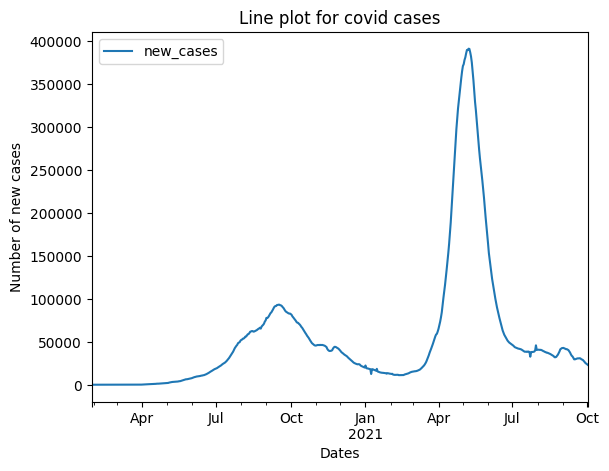

In [7]:
df.plot(y="new_cases", title="Line plot for covid cases")
plt.xlabel("Dates")
plt.ylabel("Number of new cases")
plt.show()

In [8]:
df["lag_1"] = df["new_cases"].shift(1)
correlation, _ = pearsonr(df.dropna()["lag_1"], df.dropna()["new_cases"])
print(f"The correlation between the time series and its lag 1 is = {correlation}")

The correlation between the time series and its lag 1 is = 0.9990644144715023


In [9]:
df.isnull().sum()

new_cases    0
lag_1        1
dtype: int64

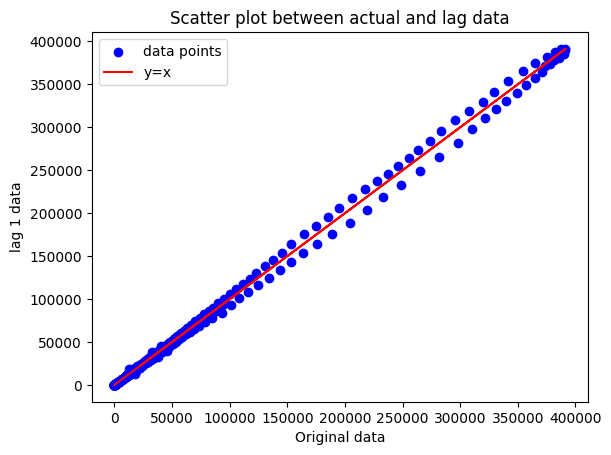

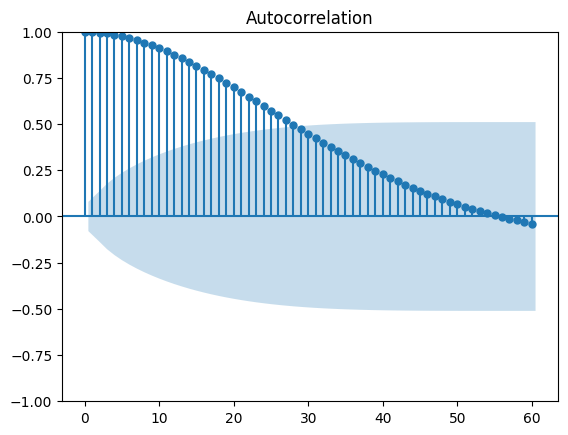

In [10]:
plt.scatter(df.dropna()["new_cases"], df.dropna()["lag_1"], label="data points",color="blue")
plt.title("Scatter plot between actual and lag data")
plt.xlabel("Original data")
plt.ylabel("lag 1 data")

plt.plot(df["new_cases"], df["new_cases"], label="y=x", color="red")
plt.legend()
plt.show()

plot_acf(df.dropna()["new_cases"], lags = 60)
plt.show()

In [11]:
breaking_point = int(len(df)*0.65)
train = df.iloc[:breaking_point]
test = df.iloc[breaking_point:]

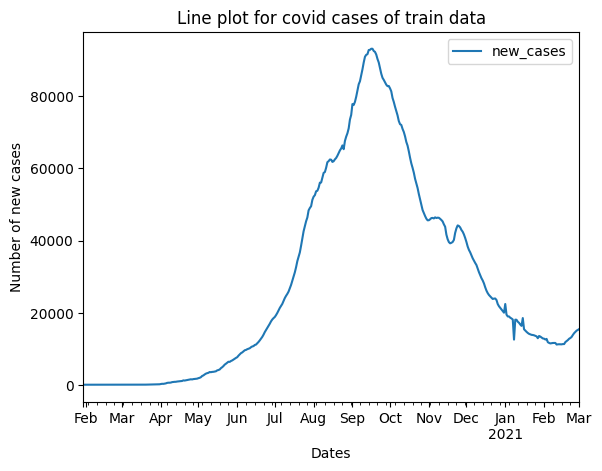

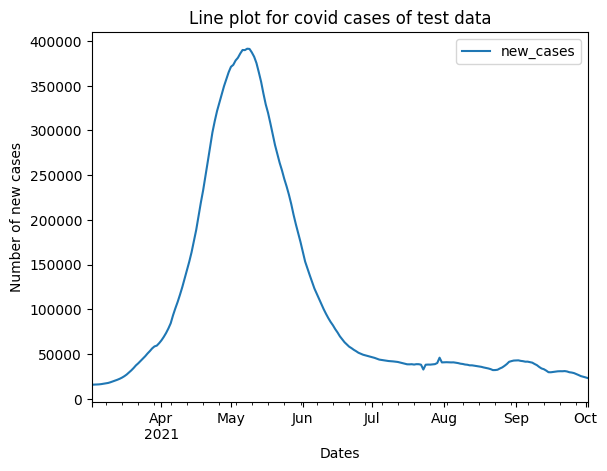

In [12]:
train.plot(y="new_cases", title="Line plot for covid cases of train data")
plt.xlabel("Dates")
plt.ylabel("Number of new cases")
plt.show()

test.plot(y="new_cases", title="Line plot for covid cases of test data")
plt.xlabel("Dates")
plt.ylabel("Number of new cases")
plt.show()

Coefficients for AR(5) is : 
const           59.954833
new_cases.L1     1.036759
new_cases.L2     0.261712
new_cases.L3     0.027561
new_cases.L4    -0.175392
new_cases.L5    -0.152461
dtype: float64


/home/user/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


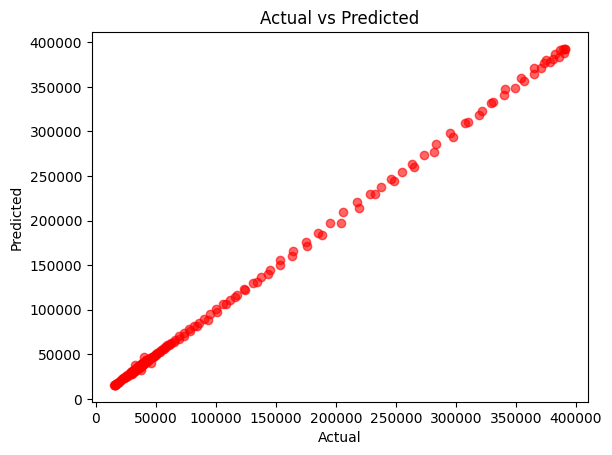

In [13]:
lag = 5
model = AR(train["new_cases"], lags= lag).fit()
coeff = model.params
print(f"Coefficients for AR({lag}) is : \n{coeff}")

history = list(train["new_cases"].values)
predictions =[]
for t in range(len(test)):
    lag_values = history[-lag:]
    
    p = coeff[0] + sum(coeff[i+1] * lag_values[lag-i-1] for i in range(lag))

    predictions.append(p)

    history.append(test["new_cases"].iloc[t])

plt.scatter(test["new_cases"], predictions, color="red", alpha=0.6)
plt.title("Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

/tmp/ipykernel_247646/2002794572.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted"] = predictions


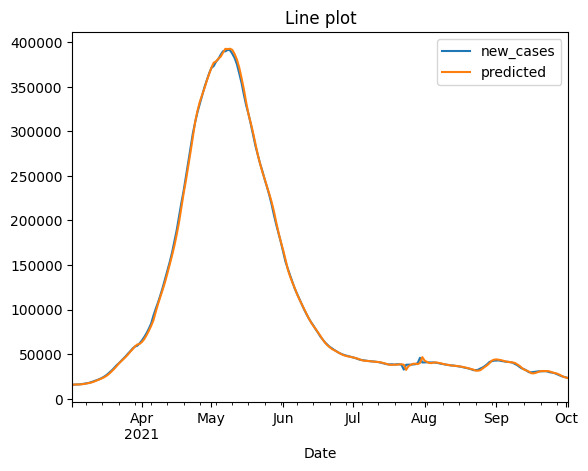

In [14]:
test["predicted"] = predictions
test.plot(y=["new_cases", "predicted"], title="Line plot")
plt.show()

In [15]:
len(test[test["new_cases"] != 0])

215

In [ ]:
len(test)

In [ ]:
test_rmse = np.sqrt(mean_squared_error(test["new_cases"], test["predicted"]))
test_mape = mean_absolute_percentage_error(test["new_cases"], test["predicted"]) * 100
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAPE: {test_mape:.2f}%")

In [ ]:
lag_list =[1,5,10,15,20,25,30,35,40,45,50,55,60]
rmse_list ={}
mape_list={}

In [ ]:
for k in lag_list:
    lag = k
    model = AR(train["new_cases"], lags= lag).fit()
    coeff = model.params
    # print(f"Coefficients for AR({lag}) is : \n{coeff}")

    history = list(train["new_cases"].values)
    predictions =[]
    for t in range(len(test)):
        lag_values = history[-lag:]
    
        p = coeff[0] + sum(coeff[i+1] * lag_values[lag-i-1] for i in range(lag))

        predictions.append(p)

        history.append(test["new_cases"].iloc[t])

    test[f"predicted_{k}"] = predictions
    rmse_list[k] = np.sqrt(mean_squared_error(test["new_cases"], test[f"predicted_{k}"]))
    mape_list[k] = mean_absolute_percentage_error(test["new_cases"], test[f"predicted_{k}"]) * 100
    
    test.plot(y=["new_cases", f"predicted_{k}"], title="Line plot")
    plt.show()
    

In [ ]:
rmse_keys = list(rmse_list.keys())
rmse_values = list(rmse_list.values())

plt.bar(rmse_keys, rmse_values)
plt.title("RMSE values for each lag value")
plt.xlabel("Lag value")
plt.ylabel("RMSE value")
plt.show()

In [ ]:
mape_keys = list(mape_list.keys())
mape_values = list(mape_list.values())

plt.bar(mape_keys, mape_values)
plt.title("MAPE values for each lag value")
plt.xlabel("Lag value")
plt.ylabel("MAPE value")
plt.show()

In [ ]:
print(f"MAPE list :\n{mape_list}")
print(f"RMSE list :\n{rmse_list}")

In [ ]:
val = plot_acf(train.dropna()["new_cases"], lags = len(train)-2).axes[0].lines[1].get_ydata()
T = len(train)
threshold = 2/np.sqrt(T)
heuristic_value = np.argmax(np.abs(val) < threshold) -1

In [ ]:
heuristic_value

In [ ]:
# correlation_list ={}
# for i in range(len(train)-2):
#     train["lag_temp"] = train["new_cases"].shift(i)
#     correlation_list[i], _ = pearsonr(train.dropna()["new_cases"],train.dropna()["lag_temp"])
# for i in range(len(df)-2):
#     if (np.abs(correlation_list[i]) < threshold):
#         h_temp = i-1
#         break;
# h_temp

In [ ]:
threshold

In [ ]:
heuristic_value

In [ ]:
lag = heuristic_value
model = AR(train["new_cases"], lags= lag).fit()
coeff = model.params
# print(f"Coefficients for AR({lag}) is : \n{coeff}")

history = list(train["new_cases"].values)
predictions =[]
for t in range(len(test)):
    lag_values = history[-lag:]
    
    p = coeff[0] + sum(coeff[i+1] * lag_values[lag-i-1] for i in range(lag))

    predictions.append(p)

    history.append(test["new_cases"].iloc[t])

test["predicted_heuristic"] = predictions
test_rmse = np.sqrt(mean_squared_error(test["new_cases"], test["predicted_heuristic"]))
test_mape = mean_absolute_percentage_error(test["new_cases"], test["predicted_heuristic"]) * 100
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAPE: {test_mape:.2f}%")